In [1]:
#　必要なライブラリのインポート　#

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
from PIL import Image
import numpy as np
import pandas as pd
from sklearn import datasets, model_selection
import sys
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#　ドライブからのファイルの引き出し　#

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
#　配列サイズや情報の割合などの指定　#

x = 64 # 0<x<128　画像情報と時間情報の割合をここで指定　最小0で最大が128

view = ['sea','mnt','sky','bld'] #　風景情報　それぞれ対応する数字は0～3
time = ['day','sns','nit']
time_number = []
for i in range(len(time)):  time_number.append(1.0/len(time)*i) #　時間情報　こちらは0.0～1.0で正規化
image_width = 128 - x #　画像ファイルの配列サイズ
image_length = 128 
time_width = x  #　時間情報の配列サイズ xに従って可変
time_length = 128

In [48]:
#　画像とファイル名を読み込む　#

image_data = [] #　画像情報と時間情報はこちらのリストに
label_data = [] #　風景情報はこちらのリスト
k = 0

files = os.listdir('./drive/My Drive/jk/') #　ドライブからアップデート

for f in files:
  img = Image.open('./drive/My Drive/jk/' + f, 'r') #　ファイル名と画像情報の読み込み

  #########　学習データの作成　#########
  resize_img = img.resize((image_length, image_width)) #　画像のリサイズ
  r, g, b = resize_img.split() #　画像をRBG値配列に分割
  r_resize_img = np.asarray(np.float32(r)/255.0)
  g_resize_img = np.asarray(np.float32(g)/255.0)
  b_resize_img = np.asarray(np.float32(b)/255.0) #　RGB値の正規化

  time_name = f[4:7] #　ファイル名から時間情報を抜き出す
  j = 0
  for s in time: #　時間情報を0～1に変換　ここではday:0、sns:0.333…、nit:0.666…となっている
    if(time_name==s):
      time_array_number = time_number[j]
    j += 1
  time_array = np.full((time_width, time_length), time_array_number) #　正規化された時間情報の配列を作る
  a = np.concatenate([r_resize_img, time_array]) #　RGB値にそれぞれくっ付ける
  b = np.concatenate([g_resize_img, time_array])
  c = np.concatenate([b_resize_img, time_array])
  rgb_resize_img = np.asarray([a, b, c]) #　RGB値配列を元に戻す(一つの画像にくっ付け直す)
  image_data.append(rgb_resize_img) #　下準備が整ったのでリストに追加

  #########　教師データの作成　#########
  view_name = f[0:3] #　それぞれ対応する数字に変換
  if(view_name=='sea'):
    view_array_number = 0
  if(view_name=='mnt'):
    view_array_number = 1
  if(view_name=='sky'):
    view_array_number = 2
  if(view_name=='bld'):
    view_array_number = 3
  label_data.append(view_array_number) #　リストに追加
  k += 1
  if((k+1)%50==0):
    print(k+1)
    print("load_OK")

50
load_OK
100
load_OK
150
load_OK
200
load_OK
250
load_OK
300
load_OK
350
load_OK


In [ ]:
image_data

In [50]:
#　テンソルへ変換　#
data = np.array(image_data, dtype='float32')
label = np.array(label_data, dtype='int64')

#　学習データとテストデータに分割　#
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(
    data, label, test_size=0.1)

print(len(train_Y))
print(len(test_Y))

322
36


In [51]:
#　テンソルへ変換　#
train_X = torch.from_numpy(train_X).float()
train_Y = torch.from_numpy(train_Y).long()

In [52]:
#　学習のライブラリに合わせて成型  #
train = TensorDataset(train_X, train_Y)
train_loader = DataLoader(train, batch_size=32, shuffle=True)

In [53]:
#　CNNの設計　#
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, 5)
    self.conv2 = nn.Conv2d(10, 20, 5)
    self.fc1 = nn.Linear(20*29*29, 50) #　((((128-5)+1)/2-5)+1)/2 = 29
    self.fc2 = nn.Linear(50, 4) # 出力は4パターン
  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, 20*29*29)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x)

model = Net()

In [54]:
#　学習　#
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epoch_list = []
loss_list = []

for epoch in range(300):
  total_loss = 0
  for train_x, train_y in train_loader:
    train_x, train_y = Variable(train_x), Variable(train_y)
    optimizer.zero_grad()
    output = model(train_x)
    loss = criterion(output, train_y)
    loss.backward()
    optimizer.step()
    total_loss += loss.data.item()
  
  if (epoch+1) % 50 == 0:
    epoch_list.append(epoch+1)
    loss_list.append(total_loss)
    print(epoch+1, total_loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


50 0.060965039461734705
100 0.006155564187793061
150 0.0022276737145148218
200 0.0010464502702234313
250 0.0006348730676108971
300 0.0003696316098285024


In [55]:
print(epoch_list)
print(loss_list)

[50, 100, 150, 200, 250, 300]
[0.060965039461734705, 0.006155564187793061, 0.0022276737145148218, 0.0010464502702234313, 0.0006348730676108971, 0.0003696316098285024]


In [56]:
#　テストデータを使ってチェックする為にこちらもテンソルに変換　#
test_X = np.array(test_X, dtype='float32')
test_Y = np.array(test_Y, dtype='int64')

test_X = torch.from_numpy(test_X).float()
test_Y = torch.from_numpy(test_Y).long()

In [57]:
#　性能チェック　#
test_x, test_y = Variable(test_X), Variable(test_Y)
result = torch.max(model(test_x).data, 1)[1]
accuracy = sum(test_y.data.numpy() == result.numpy()) / len(test_y.data.numpy())
accuracy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


0.5277777777777778

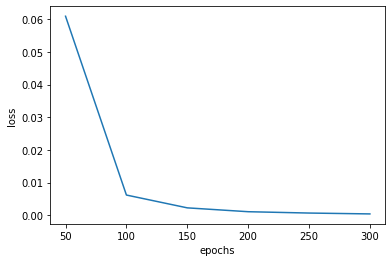

In [58]:
#　グラフに描画　#
x = np.array(epoch_list)
y = np.array(loss_list)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(x, y)
plt.show()